Importing necessrary libraries

In [1]:
import numpy as np
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

Generating Data randomly with a nonlinear calculation method for target

In [2]:
n_samples = 2000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)
x4 = random_state.uniform(size=n_samples) 
X = np.c_[x1,x2,x3,x4]

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
Y = random_state.binomial(1, p, size=n_samples)

Standardizing and generating Train-Test Split

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.3, random_state=0)

Model Results Dict

In [4]:
Model_Results = {}

Sklearn Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR_model = LogisticRegression()
t_start = time.time()
LR_model.fit(X_train, Y_train)
t_end = time.time()

LR_training_time = t_end - t_start

Y_LR_Pred = LR_model.predict(X_train)
LR_train_accuracy = accuracy_score(Y_train, Y_LR_Pred)

Y_LR_Pred_t = LR_model.predict(X_test)
LR_test_accuracy = accuracy_score(Y_test, Y_LR_Pred_t)

Model_Results["Logistic Regression"] = (LR_train_accuracy, LR_test_accuracy, LR_training_time)
print(Model_Results["Logistic Regression"])

(0.745, 0.72, 0.004001617431640625)


SVM

In [7]:
from sklearn.svm import SVC

SVM_model = SVC()
t_start = time.time()
SVM_model.fit(X_train, Y_train)
t_end = time.time()

SVM_training_time = t_end - t_start

Y_SVM_Pred = SVM_model.predict(X_train)
SVM_train_accuracy = accuracy_score(Y_train, Y_SVM_Pred)

Y_SVM_Pred_t = SVM_model.predict(X_test)
SVM_test_accuracy = accuracy_score(Y_test, Y_SVM_Pred_t)

Model_Results["SVM"] = (SVM_train_accuracy, SVM_test_accuracy, SVM_training_time)
print(Model_Results["SVM"])

(0.7628571428571429, 0.715, 0.058847665786743164)


LGBM

In [13]:
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

LGB_train = lgb.Dataset(X_train, Y_train)
LGB_test = lgb.Dataset(X_test, Y_test)

## defaults num_leaves = 31,
params = {'force_col_wise': True, 'boosting_type': 'gbdt', 'num_iterations': 100,
         'n_estimators': 100, 'max_depth': 5, 'num_leaves': 100, 'feature_fraction': 0.75,
         'bagging_fraction': 0.75, 'bagging_freq': 1, 'lambda': 0.5, 'random_state': 3, 'verbose': -1}

t_start = time.time()
LGB_model = lgb.train(params, LGB_train, valid_sets=[LGB_train, LGB_test])
t_end = time.time()

LGB_training_time = t_end - t_start

Y_LGB_Pred = LGB_model.predict(X_train)
Y_LGB_Pred = np.where(Y_LGB_Pred<0.5,0,1)
LGB_train_accuracy = accuracy_score(Y_train, Y_LGB_Pred)

Y_LGB_Pred_t = LGB_model.predict(X_test)
Y_LGB_Pred_t = np.where(Y_LGB_Pred<0.5,0,1)
LGB_test_accuracy = accuracy_score(Y_train, Y_LGB_Pred_t)

Model_Results["LGB"] = (LGB_train_accuracy, LGB_test_accuracy, LGB_training_time)
print(Model_Results["LGB"])

(0.8535714285714285, 0.8535714285714285, 0.128615140914917)


Pytorch

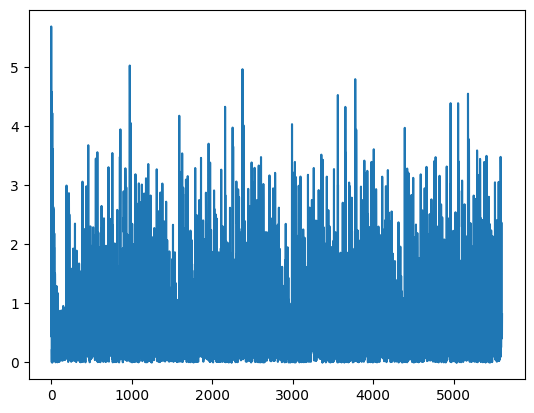

In [46]:
import matplotlib.pyplot as plt

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32)

D_in, H1, H2, D_out = 4, 7, 7, 4

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out)

)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-2
last = 1.0
error = 1.0
t = 0
errors = []

while (t<5000 and error>0.000001):
    if t % 100 == 99:
        print(t, loss.item())

    for i in range(X_train_torch.shape[0]):
        Y_pred = model(X_train_torch[i])
        loss = loss_fn(Y_pred, Y_train_torch[i])
        model.zero_grad()
        loss.backward()
        error = abs(last-loss.item())
        errors.append(error)
        last = loss.item()

        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        t += 1

plt.plot(errors)

In [44]:
print()

torch.Size([600])
(1400, 4)
torch.Size([1400, 4])
(1400,)
torch.Size([1400])
[0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0
 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0
 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1
 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0
 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0
 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1
 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1
 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1
 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1
 1 0 0 1 0 0 1 0 1 1 1 